(optional)

In [1]:
from google.colab import drive
import os
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
os.chdir('/content/drive/MyDrive/11110/ML/hw/HW5')

# **HW5: Brain signal classification**
In *HW 5*, you need to finish:

1.  Model Implementation Part: Implement LSTM and EEGNet models to predict the label of each samples.

2.  Model Competition Part: Implementing a model to reach better accuracy performance.

In [3]:
### for tracking execution time
!pip install ipython-autotime
%load_ext autotime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
time: 528 µs (started: 2023-01-04 11:03:00 +00:00)


In [4]:
import numpy as np
import os
import math
import csv
import matplotlib.pyplot as plt
# Import the packages you need here

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.constraints import max_norm

time: 3.78 s (started: 2023-01-04 11:03:00 +00:00)


In [5]:
data = np.load('data.npz')
label = np.load('label.npz')
num_classes = 6

time: 14.3 ms (started: 2023-01-04 11:03:04 +00:00)


In [6]:
X_train = data['X_train']
X_val = data['X_val']
X_test = data['X_test']

Y_train = label['Y_train']
Y_val = label['Y_val']

time: 102 ms (started: 2023-01-04 11:03:04 +00:00)


In [7]:
X_train.shape, X_val.shape, X_test.shape

((604, 22, 200), (152, 22, 200), (190, 22, 200))

time: 6.22 ms (started: 2023-01-04 11:03:04 +00:00)


In [8]:
Y_train.shape, Y_val.shape

((604, 1), (152, 1))

time: 4.83 ms (started: 2023-01-04 11:03:04 +00:00)


## Model Implementation Part

### LSTM

In [9]:
# Build your model here:
lstm_model = models.Sequential()
lstm_model.add(tf.keras.Input(shape=(X_train.shape[1], X_train.shape[2],)))
lstm_model.add(layers.LSTM(units=10, return_sequences=True))
lstm_model.add(layers.Flatten())
lstm_model.add(layers.Dense(48, activation='relu'))
lstm_model.add(layers.Dense(num_classes, activation='softmax'))
lstm_model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=3e-3), metrics='sparse_categorical_accuracy')
lstm_history = lstm_model.fit(X_train, Y_train, batch_size=16, epochs=10, validation_data=(X_val, Y_val))
#lstm_model.summary()

Epoch 1/10
38/38 [==============================] - 5s 34ms/step - loss: 1.5137 - sparse_categorical_accuracy: 0.3907 - val_loss: 1.1201 - val_sparse_categorical_accuracy: 0.6250
Epoch 2/10
38/38 [==============================] - 0s 11ms/step - loss: 0.5403 - sparse_categorical_accuracy: 0.8560 - val_loss: 0.3463 - val_sparse_categorical_accuracy: 0.8882
Epoch 3/10
38/38 [==============================] - 0s 9ms/step - loss: 0.1397 - sparse_categorical_accuracy: 0.9702 - val_loss: 0.2164 - val_sparse_categorical_accuracy: 0.9276
Epoch 4/10
38/38 [==============================] - 0s 12ms/step - loss: 0.0413 - sparse_categorical_accuracy: 0.9983 - val_loss: 0.1786 - val_sparse_categorical_accuracy: 0.9474
Epoch 5/10
38/38 [==============================] - 0s 11ms/step - loss: 0.0160 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.1802 - val_sparse_categorical_accuracy: 0.9342
Epoch 6/10
38/38 [==============================] - 0s 12ms/step - loss: 0.0081 - sparse_categorical_accur

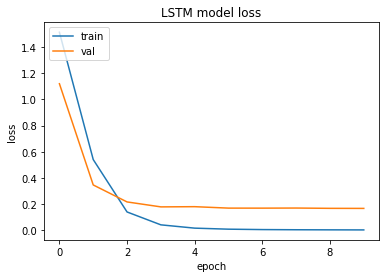

time: 383 ms (started: 2023-01-04 11:03:16 +00:00)


In [10]:
plt.plot(lstm_history.history['loss'])
plt.plot(lstm_history.history['val_loss'])
plt.title('LSTM model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [11]:
output = lstm_model.predict(X_test)
output = np.argmax(output, axis = 1).reshape(output.shape[0], 1).astype('int')
assert(output.shape == (190, 1))
np.savetxt('lstm_output.csv', output, delimiter=",")
#print(output)

6/6 [==============================] - 1s 6ms/step
time: 986 ms (started: 2023-01-04 11:03:17 +00:00)


### EEGNet

In [12]:
# Build your model here:
eegnet = models.Sequential()
eegnet.add(tf.keras.Input(shape=(X_train.shape[1], X_train.shape[2], 1)))
#block1
eegnet.add(layers.Conv2D(32, (1, X_train.shape[2]), padding="same"))
eegnet.add(layers.BatchNormalization())
eegnet.add(layers.DepthwiseConv2D(X_train.shape[1], 1, depth_multiplier=2, depthwise_constraint=max_norm(1.)))
eegnet.add(layers.BatchNormalization())
eegnet.add(layers.Activation('elu'))
eegnet.add(layers.AveragePooling2D((1, 4)))
eegnet.add(layers.Dropout(0.25))
#block2
eegnet.add(layers.SeparableConv2D(96, (1, 16), padding='same'))
eegnet.add(layers.BatchNormalization())
eegnet.add(layers.Activation('elu'))
eegnet.add(layers.AveragePooling2D((1, 8)))
eegnet.add(layers.Dropout(0.25))

eegnet.add(layers.Flatten())
eegnet.add(layers.Dense(num_classes, activation='softmax', kernel_constraint=max_norm(0.25)))

eegnet.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=3e-3), metrics='sparse_categorical_accuracy')
eegnet_history = eegnet.fit(X_train, Y_train, batch_size=16, epochs=10, validation_data=(X_val, Y_val))
#eegnet.summary()

Epoch 1/10
38/38 [==============================] - 4s 21ms/step - loss: 0.8067 - sparse_categorical_accuracy: 0.7517 - val_loss: 0.4439 - val_sparse_categorical_accuracy: 0.8947
Epoch 2/10
38/38 [==============================] - 0s 12ms/step - loss: 0.3653 - sparse_categorical_accuracy: 0.9288 - val_loss: 0.3069 - val_sparse_categorical_accuracy: 0.9803
Epoch 3/10
38/38 [==============================] - 0s 11ms/step - loss: 0.2838 - sparse_categorical_accuracy: 0.9470 - val_loss: 0.2901 - val_sparse_categorical_accuracy: 0.9671
Epoch 4/10
38/38 [==============================] - 0s 12ms/step - loss: 0.2228 - sparse_categorical_accuracy: 0.9619 - val_loss: 0.1860 - val_sparse_categorical_accuracy: 0.9868
Epoch 5/10
38/38 [==============================] - 0s 11ms/step - loss: 0.1970 - sparse_categorical_accuracy: 0.9652 - val_loss: 0.1471 - val_sparse_categorical_accuracy: 0.9803
Epoch 6/10
38/38 [==============================] - 0s 12ms/step - loss: 0.1442 - sparse_categorical_accu

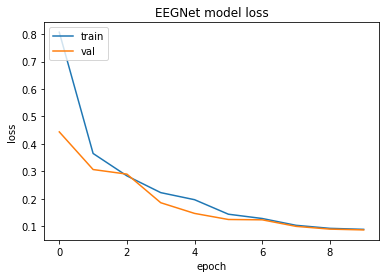

time: 145 ms (started: 2023-01-04 11:03:26 +00:00)


In [13]:
plt.plot(eegnet_history.history['loss'])
plt.plot(eegnet_history.history['val_loss'])
plt.title('EEGNet model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [14]:
output = eegnet.predict(X_test)
output = np.argmax(output, axis = 1).reshape(output.shape[0], 1).astype('int')
assert(output.shape == (190, 1))
np.savetxt('eegnet_output.csv', output, delimiter=",")
#print(output)

6/6 [==============================] - 0s 9ms/step
time: 293 ms (started: 2023-01-04 11:03:26 +00:00)


## Model Competition Part

In [15]:
# Build your model here:
model = eegnet

time: 599 µs (started: 2023-01-04 11:03:27 +00:00)


In [16]:
output = model.predict(X_test)
output = np.argmax(output, axis = 1).reshape(output.shape[0], 1).astype('int')
assert(output.shape == (190, 1))
np.savetxt('competition_output.csv', output, delimiter=",")
#print(output)

6/6 [==============================] - 0s 7ms/step
time: 112 ms (started: 2023-01-04 11:03:27 +00:00)


time: 125 ms (started: 2023-01-04 11:03:27 +00:00)
